In [1]:
#!pip install numba

## Package imports

In [2]:
import numba
import numba.cuda as cuda

import numpy as np
import matplotlib.pyplot as plt

import cv2
import PIL
from PIL import Image

import time
import io
import urllib

## Image import

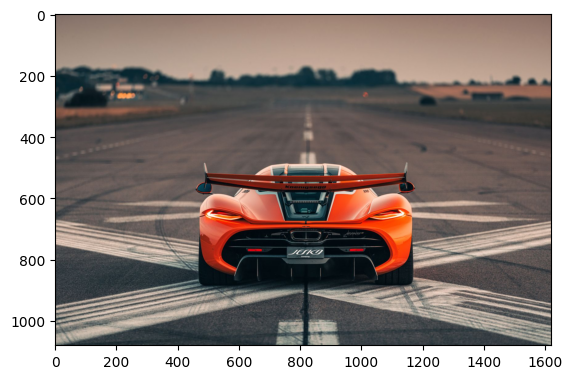

In [3]:
image_url = "https://raw.githubusercontent.com/ntacv/ntacv.github.io/refs/heads/main/assets/images/coding.jpg"
image_url = "https://raw.githubusercontent.com/ntacv/ntacv.github.io/refs/heads/main/assets/images/jesko.jpg"

host_data = np.array(PIL.Image.open(urllib.request.urlopen(image_url)))

plt.imshow(host_data)
plt.show()

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#host_data = plt.imread("/content/drive/MyDrive/jesko.jpg")
#plt.imshow(host_data)
#plt.show()

## Variables

In [5]:
height = host_data.shape[0]
width = host_data.shape[1]
block_size = (16,16)

gridX = (height + block_size[0] -1 )// block_size[0]
gridY = (width + block_size[1] -1) // block_size[1]
grid_size = (gridY,gridX)

window_size = 5
nbTest = 2

print("sizes : ")
print("rgb_data: ("+str(height)+";"+str(width)+")")
print("block: "+str(block_size)+"; grid: "+str(grid_size))

sizes : 
rgb_data: (1080;1619)
block: (16, 16); grid: (102, 68)


## Functions

In [6]:

@cuda.jit
def max_shared(d_input, d_maximum):
  gtid = cuda.grid(1)
  ltid = cuda.threadIdx.x
  bdim = cuda.blockDim.x

  shared = cuda.shared.array(shape=d_input.shape, dtype=d_input.dtype)

  shared[ltid] = d_input[gtid] if gtid < d_input.size else 0
  cuda.syncthreads()

  j=1#jump
  while j<bdim:
    if (gtid + j < d_input.size) and (ltid + j > bdim):
      temp = shared[ltid + j]
    cuda.syncthreads()
    if (gtid + j < d_input.size) and (ltid + j > bdim):
      if shared[ltid] < temp:
        shared[ltid] = temp
    j*=2
    cuda.syncthreads()

  if ltid == 0:
    d_maximum[cuda.blockIdx.x] = shared[0]

@cuda.jit
def binarization(value,threshold):
  if (value > threshold):
    return 1
  else: return 0


@cuda.jit
def map_binary(src, dst):
  #dst[tid] = f(src[tid])
  threshold = 0.5 * 255
  #tid = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  srcSizeW = src.shape[1]
  srcSizeH = src.shape[0]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  x = tidx #% srcSize
  y = tidy #// srcSize
  if x < srcSizeW and y < srcSizeH:
    bin = binarization(src[y,x,0], threshold)
    dst[y,x,0] = dst[y,x,1] = dst[y,x,2] = bin*255


@cuda.jit
def grayscale(src, dst):
  srcSizeW = src.shape[1]
  srcSizeH = src.shape[0]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  x = tidx #% srcSize
  y = tidy #// srcSize
  if x < srcSizeW and y < srcSizeH:
    gray = np.uint8 ((src[y,x,0]+src[y,x,1]+ src[y,x,2]) / 3)
    dst[y,x, 0] = dst[y,x, 1] = dst[y,x, 2] = gray


In [7]:
@cuda.jit
def rgb_to_hsv_kernel(rgb_data, H, S, V):
    height, width, _ = rgb_data.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        r = rgb_data[x, y, 0] / 255.0
        g = rgb_data[x, y, 1] / 255.0
        b = rgb_data[x, y, 2] / 255.0

        rgb_max = max(r, g, b)
        rgb_min = min(r, g, b)
        rgb_delta = rgb_max - rgb_min

        V[x, y] = rgb_max

        if rgb_max == 0:
            S[x, y] = 0
        else:
            S[x, y] = rgb_delta / rgb_max

        if rgb_delta == 0:
            H[x, y] = 0
        elif rgb_max == r:
            H[x, y] = (60 * ((g - b) / rgb_delta) + 360) % 360
        elif rgb_max == g:
            H[x, y] = (60 * ((b - r) / rgb_delta) + 120) % 360
        elif rgb_max == b:
            H[x, y] = (60 * ((r - g) / rgb_delta) + 240) % 360

@cuda.jit
def hsv_to_rgb_kernel(H, S, V, rgb_data):
    height, width = H.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        h = H[x, y]
        s = S[x, y]
        v = V[x, y]

        if s == 0:
            rgb_data[x, y, 0] = rgb_data[x, y, 1] = rgb_data[x, y, 2] = int(v * 255)
        else:
            d = h / 60
            hi = int(d) % 6
            f = d - hi
            l = v * (1 - s)
            m = v * (1 - f * s)
            n = v * (1 - (1 - f) * s)

            if hi == 0:
                rgb_data[x, y, 0] = int(v * 255)
                rgb_data[x, y, 1] = int(n * 255)
                rgb_data[x, y, 2] = int(l * 255)
            elif hi == 1:
                rgb_data[x, y, 0] = int(m * 255)
                rgb_data[x, y, 1] = int(v * 255)
                rgb_data[x, y, 2] = int(l * 255)
            elif hi == 2:
                rgb_data[x, y, 0] = int(l * 255)
                rgb_data[x, y, 1] = int(v * 255)
                rgb_data[x, y, 2] = int(n * 255)
            elif hi == 3:
                rgb_data[x, y, 0] = int(l * 255)
                rgb_data[x, y, 1] = int(m * 255)
                rgb_data[x, y, 2] = int(v * 255)
            elif hi == 4:
                rgb_data[x, y, 0] = int(n * 255)
                rgb_data[x, y, 1] = int(l * 255)
                rgb_data[x, y, 2] = int(v * 255)
            elif hi == 5:
                rgb_data[x, y, 0] = int(v * 255)
                rgb_data[x, y, 1] = int(l * 255)
                rgb_data[x, y, 2] = int(m * 255)


## Executions

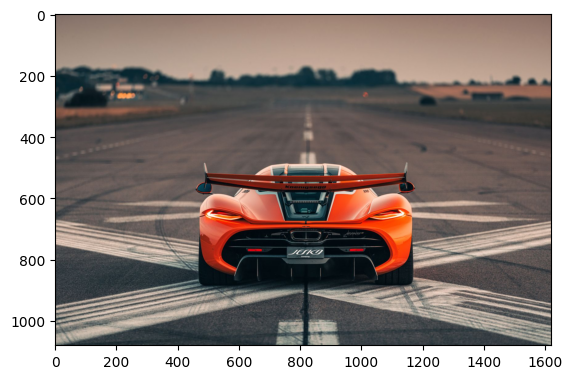

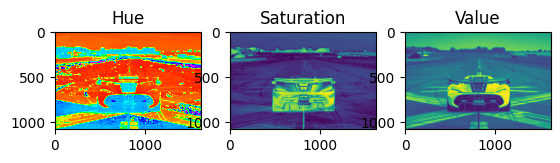

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


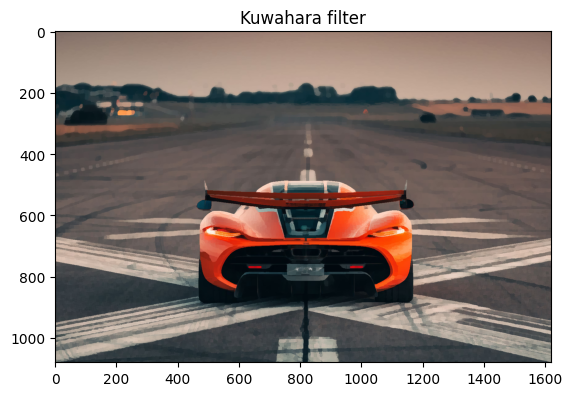

Time to run is: 1.1483395099639893


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


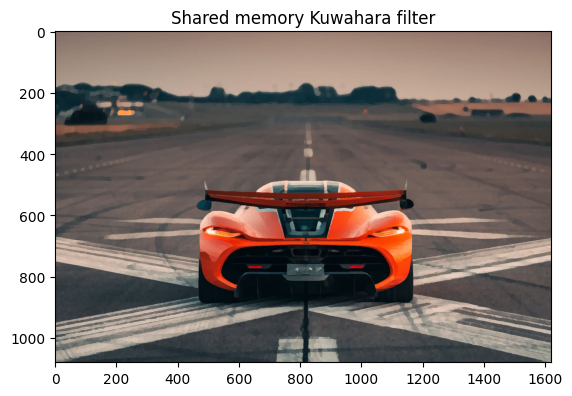

Time to run is: 1.999419927597046


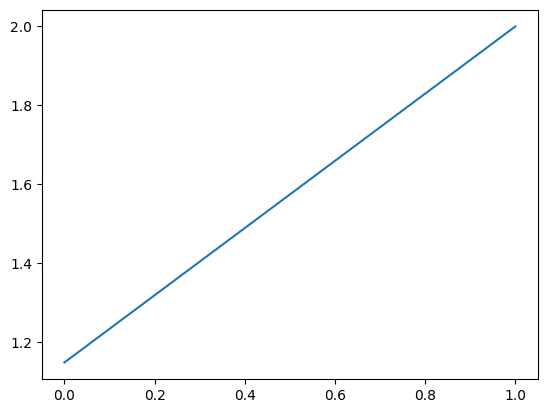

In [8]:
@cuda.jit
def kuwuhara_shared_kernel(rgb_data, H, S, V, rgb_output, window_size):
    height, width, _ = rgb_data.shape

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    block_x = cuda.blockIdx.x
    block_y = cuda.blockIdx.y

    block_width = cuda.blockDim.x
    block_height = cuda.blockDim.y

    x = block_x * block_width + tx
    y = block_y * block_height + ty

    x_temp = block_width + 2 * window_size #32+2*5=42
    y_temp = block_height + 2 * window_size #32+2*5=42

    H_shared = cuda.shared.array((42, 42), dtype=np.float32)
    S_shared = cuda.shared.array((42, 42), dtype=np.float32)
    V_shared = cuda.shared.array((42, 42), dtype=np.float32)
    R_shared = cuda.shared.array((42, 42), dtype=np.float32)
    G_shared = cuda.shared.array((42, 42), dtype=np.float32)
    B_shared = cuda.shared.array((42, 42), dtype=np.float32)

    for dy in range(0, y_temp, block_height):
        for dx in range(0, x_temp, block_width):
            y_shared = ty + dy
            x_shared = tx + dx
            y_global = y - window_size + dy
            x_global = x - window_size + dx

            if (y_global >= 0 and y_global < height and
                x_global >= 0 and x_global < width):
                H_shared[y_shared, x_shared] = H[y_global, x_global]
                S_shared[y_shared, x_shared] = S[y_global, x_global]
                V_shared[y_shared, x_shared] = V[y_global, x_global]
                R_shared[y_shared, x_shared] = rgb_data[y_global, x_global, 0]
                G_shared[y_shared, x_shared] = rgb_data[y_global, x_global, 1]
                B_shared[y_shared, x_shared] = rgb_data[y_global, x_global, 2]
            else:
                H_shared[y_shared, x_shared] = 0.0
                S_shared[y_shared, x_shared] = 0.0
                V_shared[y_shared, x_shared] = 0.0
                R_shared[y_shared, x_shared] = 0.0
                G_shared[y_shared, x_shared] = 0.0
                B_shared[y_shared, x_shared] = 0.0
    cuda.syncthreads()

    if x < width and y < height:
        array_mean = cuda.local.array((4, 3), dtype=np.float32)
        array_variance = cuda.local.array(4, dtype=np.float32)
        for k in range(4):
            R_sum = 0.0
            G_sum = 0.0
            B_sum = 0.0
            V_sum = 0.0
            V_square = 0.0
            count = 0

            x_shared = tx + window_size
            y_shared = ty + window_size

            if k == 0:#top-left
                y_start, y_end = y_shared - window_size, y_shared + 1
                x_start, x_end = x_shared - window_size, x_shared + 1
            elif k == 1:#top-right
                y_start, y_end = y_shared - window_size, y_shared + 1
                x_start, x_end = x_shared, x_shared + window_size + 1
            elif k == 2:#bottom-left
                y_start, y_end = y_shared, y_shared + window_size + 1
                x_start, x_end = x_shared - window_size, x_shared + 1
            else:#bottom-right
                y_start, y_end = y_shared, y_shared + window_size + 1
                x_start, x_end = x_shared, x_shared + window_size + 1

            for yi in range(y_start, y_end):
                for xi in range(x_start, x_end):
                    count += 1
                    r = R_shared[yi, xi]
                    g = G_shared[yi, xi]
                    b = B_shared[yi, xi]
                    v = V_shared[yi, xi]

                    R_sum += r
                    G_sum += g
                    B_sum += b
                    V_sum += v
                    V_square += v * v

            if count > 0:
                array_mean[k, 0] = R_sum / count
                array_mean[k, 1] = G_sum / count
                array_mean[k, 2] = B_sum / count
                V_mean = V_sum / count
                array_variance[k] = (V_square / count) - (V_mean * V_mean)
            else:
                array_variance[k] = 1e10

        min_var = array_variance[0]
        min_idx = 0
        for k in range(1, 4):
            if array_variance[k] < min_var:
                min_var = array_variance[k]
                min_idx = k

        rgb_output[y, x, 0] = array_mean[min_idx, 0]
        rgb_output[y, x, 1] = array_mean[min_idx, 1]
        rgb_output[y, x, 2] = array_mean[min_idx, 2]

@cuda.jit
def kuwahara_kernel(rgb_data, H, S, V, rgb_output, window_size):
    height, width, _ = rgb_data.shape

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    block_x = cuda.blockIdx.x
    block_y = cuda.blockIdx.y

    block_width = cuda.blockDim.x
    block_height = cuda.blockDim.y

    x = block_x * block_width + tx
    y = block_y * block_height + ty

    if x < width and y < height:
        array_mean = cuda.local.array((4, 3), dtype=np.float32)
        array_variance = cuda.local.array(4, dtype=np.float32)
        for k in range(4):
            R_sum = 0.0
            G_sum = 0.0
            B_sum = 0.0
            V_sum = 0.0
            V_square = 0.0
            count = 0

            if k == 0:#top-left
                y_start, y_end = max(0, y - window_size), y + 1
                x_start, x_end = max(0, x - window_size), x + 1
            elif k == 1:#top-right
                y_start, y_end = max(0, y - window_size), y + 1
                x_start, x_end = x, min(width, x + window_size + 1)
            elif k == 2:#bottom-left
                y_start, y_end = y, min(height, y + window_size + 1)
                x_start, x_end = max(0, x - window_size), x + 1
            else:#bottom-right
                y_start, y_end = y, min(height, y + window_size + 1)
                x_start, x_end = x, min(width, x + window_size + 1)

            for yi in range(y_start, y_end):
                for xi in range(x_start, x_end):
                    count += 1
                    r = rgb_data[yi, xi, 0]
                    g = rgb_data[yi, xi, 1]
                    b = rgb_data[yi, xi, 2]
                    v = V[yi, xi]

                    R_sum += r
                    G_sum += g
                    B_sum += b
                    V_sum += v
                    V_square += v * v

            if count > 0:
                array_mean[k, 0] = R_sum / count
                array_mean[k, 1] = G_sum / count
                array_mean[k, 2] = B_sum / count
                V_mean = V_sum / count
                array_variance[k] = (V_square / count) - (V_mean * V_mean)
            else:
                array_variance[k] = 1e10

        min_var = array_variance[0]
        min_idx = 0
        for k in range(1, 4):
            if array_variance[k] < min_var:
                min_var = array_variance[k]
                min_idx = k

        rgb_output[y, x, 0] = array_mean[min_idx, 0]
        rgb_output[y, x, 1] = array_mean[min_idx, 1]
        rgb_output[y, x, 2] = array_mean[min_idx, 2]

def rgb_to_hsv():
  height, width, _ = host_data.shape
  grid_size = (gridX, gridY)

  devOutRGB = cuda.device_array((height * width, 3), np.uint8)
  hostOutRGB = np.zeros((height, width, 3), np.uint8)

  devDataH = cuda.device_array((height, width), np.uint8)
  devDataS = cuda.device_array((height, width), np.uint8)
  devDataV = cuda.device_array((height, width), np.uint8)

  devData = cuda.to_device(host_data)
  devTemp = cuda.device_array((height, width, 3), np.uint8)
  devOutput = cuda.device_array((height, width, 3), np.uint8)

  H = np.zeros((height, width), dtype=np.float32)
  S = np.zeros((height, width), dtype=np.float32)
  V = np.zeros((height, width), dtype=np.float32)

  host_data_dev = cuda.to_device(host_data)
  H_dev = cuda.to_device(H)
  S_dev = cuda.to_device(S)
  V_dev = cuda.to_device(V)

  rgb_to_hsv_kernel[grid_size, block_size](host_data_dev, H_dev, S_dev, V_dev)

  H = H_dev.copy_to_host()
  S = S_dev.copy_to_host()
  V = V_dev.copy_to_host()

  plt.subplot(1, 3, 1)
  plt.title("Hue")
  plt.imshow(H, cmap='hsv')
  plt.subplot(1, 3, 2)
  plt.title("Saturation")
  plt.imshow(S)
  plt.subplot(1, 3, 3)
  plt.title("Value")
  plt.imshow(V)
  plt.show()

  hsv_to_rgb_kernel[grid_size, block_size](H_dev, S_dev, V_dev, host_data_dev)


def kuwahara_filter(rgb_data, window_size=5, shared=False):
  height, width, _ = rgb_data.shape
  grid_size = (gridX, gridY)

  H = np.zeros((height, width), dtype=np.float32)
  S = np.zeros((height, width), dtype=np.float32)
  V = np.zeros((height, width), dtype=np.float32)

  rgb_data_dev = cuda.to_device(rgb_data)
  H_dev = cuda.to_device(H)
  S_dev = cuda.to_device(S)
  V_dev = cuda.to_device(V)

  rgb_to_hsv_kernel[grid_size, block_size](rgb_data_dev, H_dev, S_dev, V_dev)

  H = H_dev.copy_to_host()
  S = S_dev.copy_to_host()
  V = V_dev.copy_to_host()

  rgb_output = np.zeros_like(rgb_data)

  grid_size = (gridY, gridX)
  if shared:
    kuwuhara_shared_kernel[grid_size, block_size](rgb_data, H, S, V, rgb_output, window_size)
  else:
    kuwahara_kernel[grid_size, block_size](rgb_data, H, S, V, rgb_output, window_size)

  return rgb_output


plt.imshow(host_data)
plt.show()

rgb_to_hsv()

time_per_test = np.zeros(nbTest)
start_time = time.time()

rgb_output = kuwahara_filter(host_data, window_size, False)
plt.title("Kuwahara filter")
plt.imshow(rgb_output)
plt.show()

end_time = time.time()
run_time = end_time-start_time
print("Time to run is: "+ str(run_time))
start_time_shared = time.time()

rgb_output = kuwahara_filter(host_data, window_size, True)
plt.title("Shared memory Kuwahara filter")
plt.imshow(rgb_output)
plt.show()

end_time_shared = time.time()
run_time_shared = end_time_shared-start_time_shared
print("Time to run is: "+ str(run_time_shared))

time_per_test[0] = run_time
time_per_test[1] = run_time_shared
plt.plot(time_per_test)
plt.show()